# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [47]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [110]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

#Convert date to datetime and create month_day and year features for sorting
df['Date'] = pd.to_datetime(df['Date'])
df['Month_Day'] = df['Date'].dt.strftime('%m-%d')
df['Year'] = df['Date'].dt.year

#Remove leap days
df = df[df.Month_Day!='02-29']

# Sort data by month_day
df = df.sort_values(by=['Month_Day'])

#Pivot table to capture 2005-14 extremes
df2 = pd.pivot_table(df[df.Year!=2015], index='Month_Day', columns='Element', values='Data_Value', aggfunc=[min, max])
df2.columns = df2.columns.map('_'.join)
df2.drop(['min_TMAX','max_TMIN'], axis=1, inplace=True)
df2.columns = ['TMIN_min', 'TMAX_max']

#Pivot to capture 2015 extremes
df3 = pd.pivot_table(df[df.Year==2015], index='Month_Day', columns='Element', values='Data_Value', aggfunc=[min, max])
df3.columns = df3.columns.map('_'.join)
df3.drop(['min_TMAX','max_TMIN'], axis=1, inplace=True)
df3.columns = ['TMIN_2015', 'TMAX_2015']

#Join pivots
df4 = df2.join(df3)

#Create features for new 2015 record temps
df4['min_out_15'] = np.where(df4['TMIN_2015'] < df4['TMIN_min'],df4['TMIN_2015'], np.nan)
df4['max_out_15'] = np.where(df4['TMAX_2015'] > df4['TMAX_max'],df4['TMAX_2015'], np.nan)

# print(df.head())
print(df4.head())

           TMIN_min  TMAX_max  TMIN_2015  TMAX_2015  min_out_15  max_out_15
Month_Day                                                                  
01-01          -160       156       -133         11         NaN         NaN
01-02          -267       139       -122         39         NaN         NaN
01-03          -267       133        -67         39         NaN         NaN
01-04          -261       106        -88         44         NaN         NaN
01-05          -150       128       -155         28      -155.0         NaN


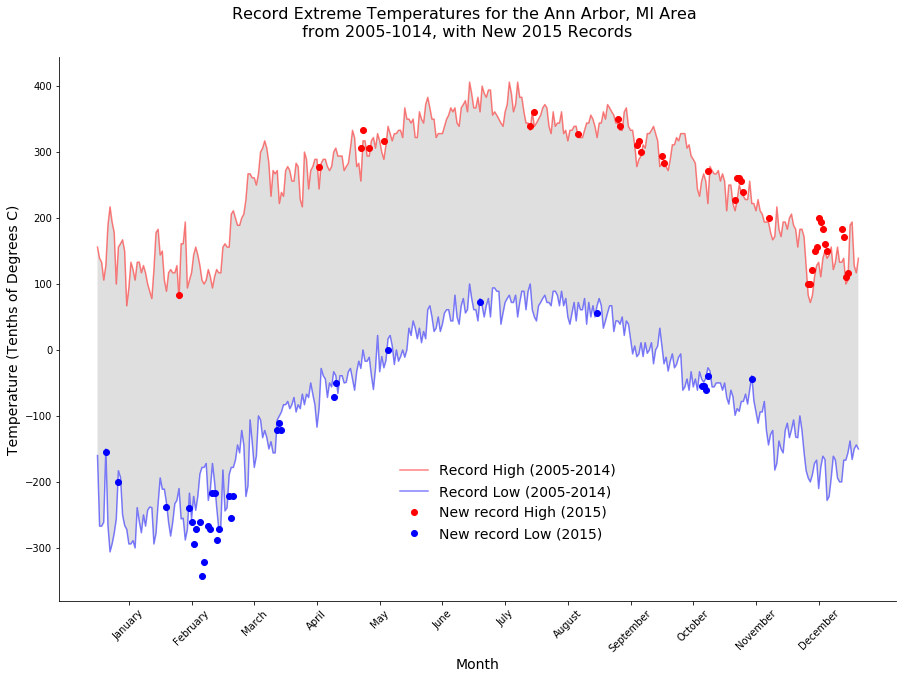

In [111]:
#Create figure
plt.figure(figsize=[15,10])

#Capture axes for modifications
ax = plt.gca()

#Create title
plt.suptitle('Record Extreme Temperatures for the Ann Arbor, MI Area\n from 2005-1014, with New 2015 Records', fontsize=16, y=.95)

#Plot 2005-14 extremes
plt.plot(range(365),df4['TMAX_max'], 'r', alpha=.5, label = 'Record High (2005-2014)')
plt.plot(range(365),df4['TMIN_min'], 'b', alpha=.5, label = 'Record Low (2005-2014)')

#Shade between extremes
ax.fill_between(range(365),df4['TMAX_max'], df4['TMIN_min'], facecolor='GRAY', alpha=0.25)

#Plot 2015 extremes
plt.plot(range(365), df4['max_out_15'], 'ro', label='New record High (2015)')
plt.plot(range(365), df4['min_out_15'], 'bo', label='New record Low (2015)')

#Add legend
plt.legend(loc=(0.4,0.1), frameon = False, fontsize=14)

#Add month names to axis
plt.xticks(np.linspace(15,15 + 30*11 , num = 12), (r'January', r'February', r'March', r'April', r'May', r'June',\
                                                   r'July', r'August', r'September', r'October', r'November',\
                                                   r'December'), rotation=45)

#axis labels
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature (Tenths of Degrees C)', fontsize=14)

#Hide top, right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()